In [16]:
import os
import nibabel as nib
from scipy.spatial import ConvexHull
import helper_functions.visualizations as vis
import helper_functions.reshape_data as rd
import helper_functions.filter_CT as fct
import helper_functions.manipulate_hull as mh
from scipy.ndimage import gaussian_laplace
import numpy as np
import importlib

In [6]:
root_data_dir = '/Users/akre96/Documents/GradSchool/Class/BE223A/BE223A_2019/data' # Change for different systems
subjects = os.listdir(root_data_dir)

subject = 'subject_1'

preop_CT_path = os.path.join(
    root_data_dir,
    os.path.join(
        subject,
        'postopCT_' + subject + '.nii'
    )
)

hull_mat_path = os.path.join(
    root_data_dir,
    os.path.join(
        subject,
        'hull.mat'
    )
)

In [7]:
subjects = os.listdir(root_data_dir)

# Loading hull and isolating skull
### Find hull, remove inside from CT, scale hull, remove outside from CT

In [8]:
print('\nLOADING CT')
# Load Preop_CT
preop_CT = nib.load(preop_CT_path)
preop_CT_data = preop_CT.get_fdata()


LOADING CT



LOADING HULL

CREATING CONVEX HULL

NORMALIZING AND RESHAPING CT DATA
Normalizing from: -1559.4481201171875 3860.324951171875
To range: 0.0 1.0


| |   #                                         | 8642818 Elapsed Time: 0:00:54
 21% (11581 of 53814) |###               | Elapsed Time: 0:00:00 ETA:   0:00:00


SCALING HULL
[140.86661699 105.81296572  89.16020864]


100% (53814 of 53814) |##################| Elapsed Time: 0:00:00 Time:  0:00:00



FILTERING CT FOR REGIONS WITHIN SCALED AND OUTSIDE ORIGINAL HULL
...Splitting data in to chunks
	Done. Chunks created: 17285
...Creating inputs
	Done
...Computing if chunks in Hull
	Done
...Splitting data in to chunks
	Done. Chunks created: 14552
...Creating inputs
	Done
...Computing if chunks in Hull
	Done

GET CURVATURE OF SKULL
Normalizing from: -0.42972564760735166 0.21408128070093424
To range: 0.0 1.0


| |                #                             | 240380 Elapsed Time: 0:00:01
  7% (34237 of 450779) |#                | Elapsed Time: 0:00:00 ETA:   0:00:01


FILTERING CT FOR UPPER REGIONS USED IN CT


100% (450779 of 450779) |################| Elapsed Time: 0:00:01 Time:  0:00:01


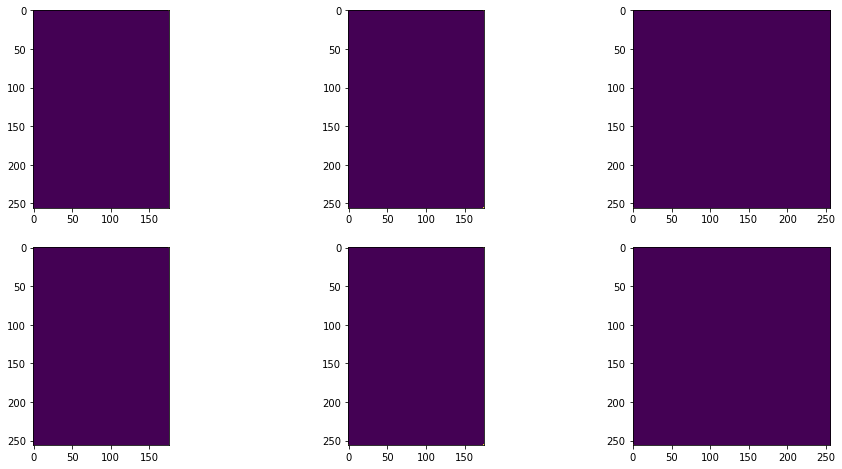

In [20]:
print('\nLOADING HULL')
# Load Hull
hull_idx = mh.load_hull_from_mat(hull_mat_path, preop_CT)

print('\nCREATING CONVEX HULL')
# Create convex hull object
point_cloud = hull_idx[:,:3]
hull_hull = ConvexHull(point_cloud)

print('\nNORMALIZING AND RESHAPING CT DATA')
# Get long CT Data
long_data = rd.voxels_to_4D(fct.min_max_normalize(preop_CT_data), is_norm=True)

print('\nSCALING HULL')
# Scale Hull by 110% (1.1)
scaled = mh.scale_hull(hull_idx, 1.1)
scaled_hull = ConvexHull(scaled[:,:3])

print('\nFILTERING CT FOR REGIONS WITHIN SCALED AND OUTSIDE ORIGINAL HULL')
# Filter long CT Data for data within hull
hull_filt_in = fct.filter_in_hull(long_data, hull_hull, filt_out=False)
hull_filt_both = fct.filter_in_hull(hull_filt_in, scaled_hull, filt_out=True)

voxel_rem_both = rd.long_to_voxels(hull_filt_both, preop_CT_data.shape)

print('\nGET CURVATURE OF SKULL')
skull_vertices = fct.get_skull_vertices(
    voxel_rem_both,
    preop_CT_data.shape,
    thresh=0.6,
    sigma=1
)

axes = vis.compare_filtered_original(voxel_rem, hull_voxel_rem);
if not set(hull_voxel_rem.flatten().tolist()) == set([0, 1]):
    raise ValueError('Not binary')
## Take convex hull then remove lower



print('\nFILTERING CT FOR UPPER REGIONS USED IN CT')
# Remove lower portion from below points in linear plane drawn from y(x=0) = 100 --> y(x=256) = 160
lower_removed = fct.remove_lower_regions(hull_filt_both, preop_CT_data.shape, init_point=100, end_point=150)
voxel_rem = rd.long_to_voxels(lower_removed, preop_CT_data.shape)

8.91203621953044 -8.992411345707893


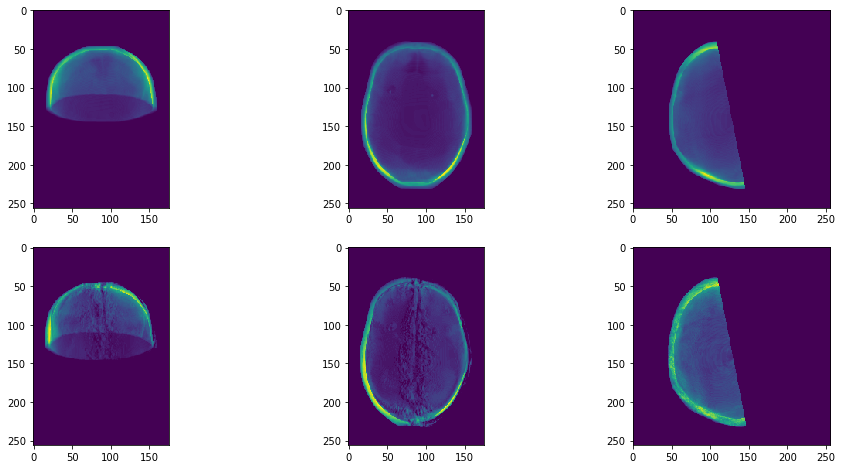

In [22]:
from scipy.ndimage import sobel
import numpy as np
sob_filt = sobel(voxel_rem)
print(sob_filt.max(), sob_filt.min())

norm = sob_filt.copy()
norm[np.where(norm < 0)] = 0
norm[np.where(norm > 0)] = 1
axes = vis.compare_filtered_original(voxel_rem, norm);

In [53]:
voxel_rem_both = rd.long_to_voxels(hull_filt_both, preop_CT_data.shape)

In [78]:
long_norm[hull_norm.vertices].shape

(1373, 4)

0.21408128070093424 -0.42972564760735166
Normalizing from: -0.42972564760735166 0.21408128070093424
To range: 0.0 1.0


- | #                                             | 16120 Elapsed Time: 0:00:00

Long_To_Norm


| |                       #                      | 384320 Elapsed Time: 0:00:02
100% (1999 of 1999) |####################| Elapsed Time: 0:00:00 Time:  0:00:00


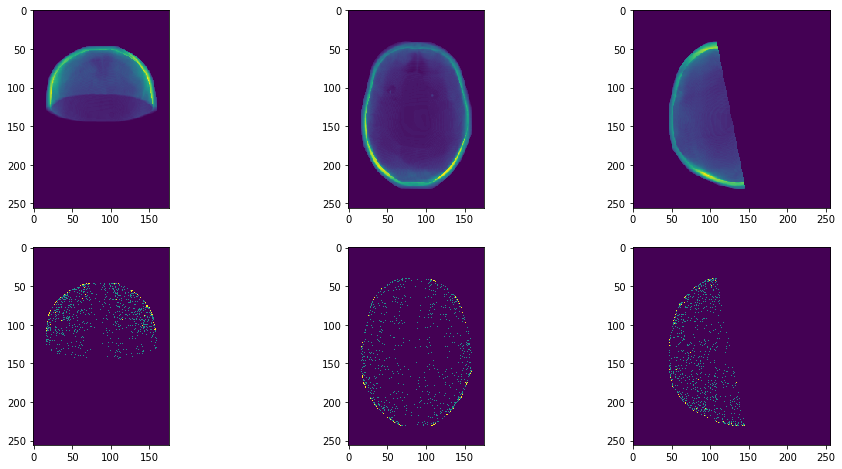

In [24]:
from scipy.ndimage import gaussian_laplace
import numpy as np
g_filt = gaussian_laplace(voxel_rem_both, sigma=1)
print(g_filt.max(), g_filt.min())
mmax = fct.min_max_normalize(g_filt)
norm = g_filt.copy()
norm[np.where(g_filt < 0)] = 1
norm[np.where(g_filt >= 0)] = 0

print('Long_To_Norm')
long_norm = rd.voxels_to_4D(norm, is_norm=True)
hull_norm = ConvexHull(long_norm[:,:3])
hull_vertices = long_norm[hull_norm.vertices]

hull_lower_removed = fct.remove_lower_regions(hull_vertices, preop_CT_data.shape, init_point=100, end_point=150)

hull_voxel_rem = rd.long_to_voxels(hull_lower_removed, preop_CT_data.shape)

axes = vis.compare_filtered_original(voxel_rem, hull_voxel_rem);
if not set(hull_voxel_rem.flatten().tolist()) == set([0, 1]):
    raise ValueError('Not binary')
## Take convex hull then remove lower

True

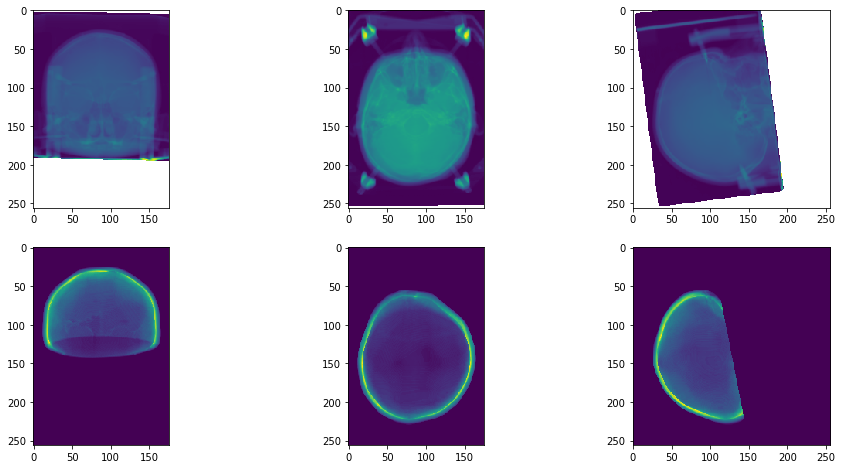

In [109]:
# Plot original CT vs segmented
axes = vis.compare_filtered_original(preop_CT_data, voxel_rem);

Text(0.5, 0, 'z')

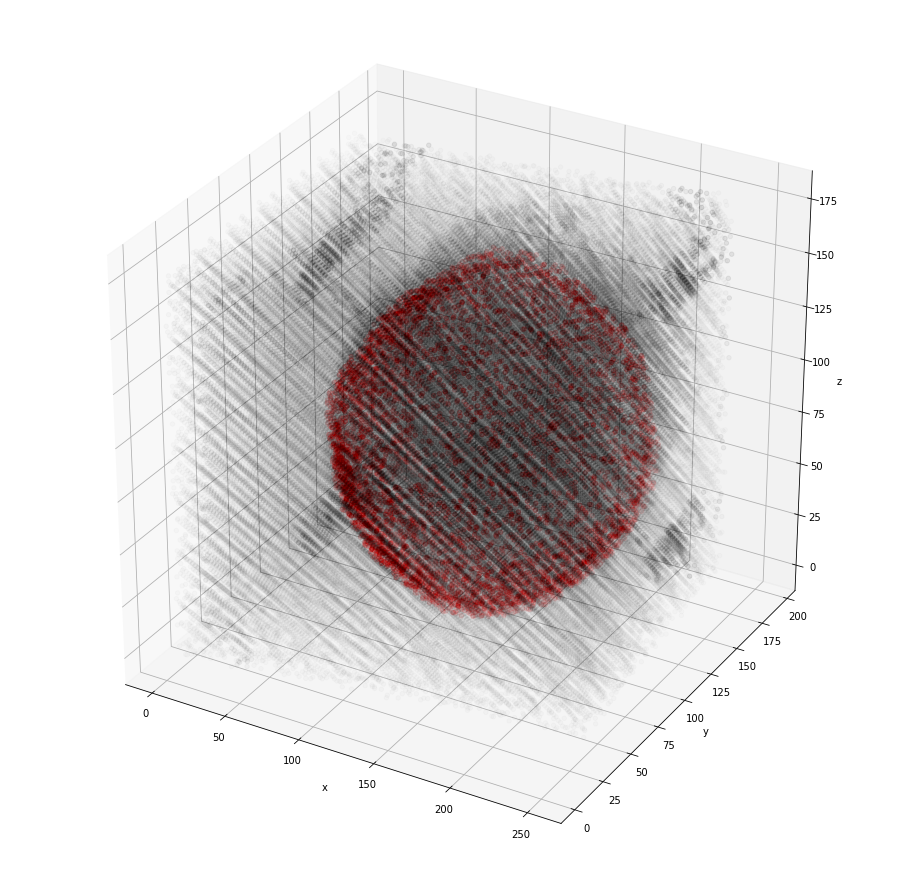

In [110]:
ax = vis.quick_plot_3D(
    lower_removed,
    is_long=True,
    is_norm=True,
    alpha_max=0.5,
    base_color=(1,0,0)
)
vis.quick_plot_3D(
    long_data,
    is_long=True,
    is_norm=True,
    alpha_max=0.2,
    step_size=50,
    ax=ax
)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

## Saving feature space CT using affine and header from original


In [13]:
feature_CT = nib.nifti1.Nifti1Image(voxel_rem, preop_CT.affine, header=preop_CT.header)

In [14]:
file_name = os.path.join(
    'output',
    subject + '_skull.nii'
)
nib.nifti1.save(feature_CT, file_name)

### Checking saved file

In [5]:
file_name = os.path.join(
    'SKULL_NII',
    subject + '_skull.nii'
)
ct = nib.load(file_name)

In [6]:
data = ct.get_fdata()

/Users/akre96/Documents/GradSchool/Class/BE223A/BE223A_2019/CT_Segmentation/helper_functions/reshape_data.py:82: RuntimeWarning: Mean of empty slice
  projection = np.nanmean(ct_data, axis=axis)


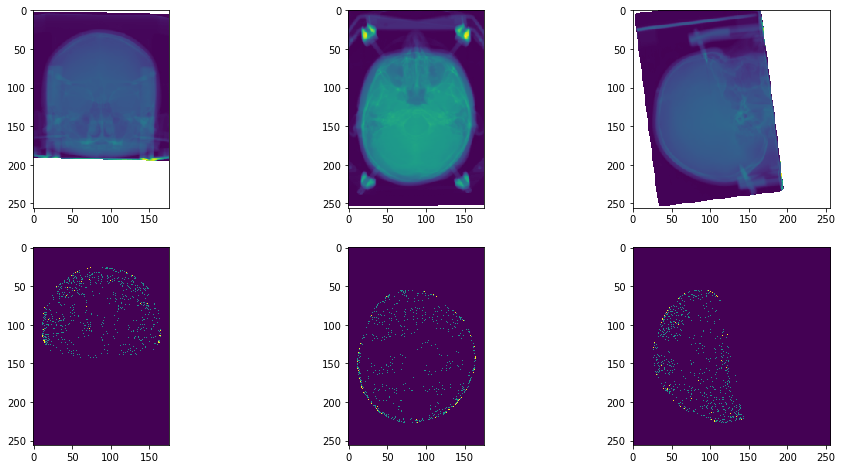

In [9]:
axes = vis.compare_filtered_original(preop_CT_data, data);